## Model for fitting phase of GW signal generated by BHs with no spins

#### Apparently this code is useless: the relation to fit is not piecewise linear but continuous over all range. Everything done so far was wrong! This was due to a mistake in dataset creation.  The lesson to take here is that I should look at the dataset and at it features a lot before doing anything: I should have saved 2 months with only a couple of hours of attention...

Each signal is decomposed into its 10 most important principal components. Then a regression is done from the indipendent variable q to each of the PC. <br>
 It appears that the relation PC(q) is piecewise linear thus the regression is done in the following 3 steps:
- identify a cluster for each linear piece of the function in the PC 0
- fit a classifier which sends every piece of the domain in the right cluster (this is done by the clustering model itself)
- do a linear regression for each of the cluster

The present notebook contains all the code to do so.

In [1]:
    #loading all the required files
import matplotlib.pyplot as plt 
import numpy as np
import time #for performances comparison
import sys
sys.path.insert(1, '../routines') #folder in which every relevant routine is saved

from GW_helper import *   #routines for dealing with datasets
from ML_routines import * #PCA model
from EM_KM import *       #cluster recognition

Using TensorFlow backend.


In [2]:
   #loading datasets...
train_theta = np.loadtxt("./old_datasets/PCA_train_theta_s1_const.dat")
val_theta = np.loadtxt("./old_datasets/PCA_test_theta_s1_const.dat")
PCA_train_ph = np.loadtxt("./old_datasets/PCA_train_s1_const.dat")
PCA_val_ph = np.loadtxt("./old_datasets/PCA_test_s1_const.dat")

    #removing spins from training data (spins must be the same for all train and test example)
s = train_theta[0,1:]
train_theta = np.reshape(train_theta[:,0], (train_theta.shape[0],1))
val_theta = np.reshape(val_theta[:,0], (val_theta.shape[0],1))

print("Loaded "+ str(train_theta.shape[0]+val_theta.shape[0])+
      " data with ",PCA_train_ph.shape[1]," features")
print("Spins fixed at s= ", s)

   #preprocessing data
max_ph = np.max(np.abs(PCA_train_ph), axis = 0)
max_ph[np.where(max_ph > 100)] /= 10.
PCA_train_ph = np.divide(PCA_train_ph,max_ph)
PCA_val_ph = np.divide(PCA_val_ph,max_ph)

Loaded 5000 data with  20  features
Spins fixed at s=  [-0.8   0.33]


In [3]:
   #model for detecting clusters in the PC 0
cl_model = K_means_linfit(train_theta.shape[1], sigma = 5e-4) #definining the model
cl_model.fit(train_theta, PCA_train_ph[:,0], K_0 = 300 ,N_iter=4) #fitting it
   #creating labels for regression
train_labels = cl_model.predict(train_theta, PCA_train_ph[:,0])
val_labels = cl_model.predict(val_theta, PCA_val_ph[:,0])
print("Model has ", str(cl_model.get_params()[1]), "clusters")

	Cluster 190 empty!
	Cluster 208 empty!
	Removed  156  clusters
	Removed  71  clusters
	Removed  17  clusters
	Removed  1  clusters
	Cluster 70 empty!
	Cluster 87 empty!
	Cluster 88 empty!
LL at iter 1=  -70.19235429688108
	Removed  2  clusters
	Removed  1  clusters
LL at iter 2=  -70.17137209049638
LL at iter 3=  -70.17137209049638
LL at iter 4=  -70.17137209049638
Model has  87 clusters


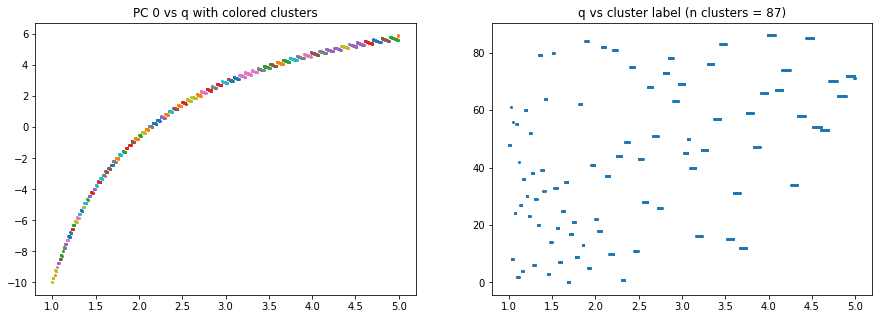

In [4]:
   #looking at validation labels
N_cl = cl_model.get_params()[1]
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2, 1)
plt.title("PC 0 vs q with colored clusters")
for k_cl in range(N_cl):
    val_theta_k = val_theta[np.where(val_labels == k_cl)[0]]
    PCA_val_ph_k = PCA_val_ph[np.where(val_labels == k_cl)[0]]
    if len(val_theta_k) !=0:
        plt.plot(val_theta_k, PCA_val_ph_k[:,0], 'o', ms = 2)
ax = plt.subplot(1,2, 2)
plt.title("q vs cluster label (n clusters = "+str(N_cl)+")")
plt.plot(val_theta, val_labels, 'o', ms = 2)
plt.show()

In [5]:
    #looking at predictions given by the model
guessed_train_labels = cl_model.predict_y(train_theta, get_labels = True)
guessed_val_labels = cl_model.predict_y(val_theta, get_labels = True)
print("Train misclustering (%): ", 100*np.sum((guessed_train_labels != train_labels))/train_labels.shape[0])
print("Val misclustering (%): ", 100*np.sum((guessed_val_labels != val_labels))/val_labels.shape[0])

Train misclustering (%):  1.775
Val misclustering (%):  2.5


In [6]:
   #regression for each cluster for each component using class predictor_lin_fit_cluster
print("Doing MoE model for each component")
print("Indipendent variables = ", train_theta.shape[1])
PCA_fit_ph = np.zeros(PCA_val_ph.shape) #to store validation results
linfit_models = []

   #train data are the data used to identify the right clusters in order to avoid misclusering
train_data_0 = np.concatenate((train_theta, np.reshape(PCA_train_ph[:,0], (PCA_train_ph.shape[0],1))), axis = 1)

for k in range(PCA_train_ph.shape[1]):
    print("Fitting component #",str(k))
    linfit_models.append(predictor_lin_fit_cluster(train_theta.shape[1], cl_model.get_params()[1], cl_model))
    linfit_models[k].fit(train_theta, PCA_train_ph[:,k], train_data_0, regularizer = 0., loss = "L1")
    PCA_fit_ph[:,k] = linfit_models[k].predict(val_theta)
    print("\tLoss for component "+str(k)+": ", linfit_models[k].evaluate_loss(val_theta, PCA_val_ph[:,k]))   

Doing MoE model for each component
Indipendent variables =  1
Fitting component # 0
	Loss for component 0:  0.002074381380666714
Fitting component # 1
	Loss for component 1:  0.05974073144683867
Fitting component # 2
	Loss for component 2:  0.0005802891843980776
Fitting component # 3


/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


	Loss for component 3:  0.0032803130652017537
Fitting component # 4
	Loss for component 4:  0.022808381553206664
Fitting component # 5
	Loss for component 5:  0.01694359335477838
Fitting component # 6
	Loss for component 6:  6.035201145610245e-06
Fitting component # 7


/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


	Loss for component 7:  0.0019491611093900097
Fitting component # 8


/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


	Loss for component 8:  2.184735050583499e-06
Fitting component # 9
	Loss for component 9:  0.002432572599693799
Fitting component # 10


/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


	Loss for component 10:  0.00011905929350725732
Fitting component # 11
	Loss for component 11:  8.678869319048869e-05
Fitting component # 12
	Loss for component 12:  1.656113045771553e-05
Fitting component # 13


/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


	Loss for component 13:  2.3856543641244767e-05
Fitting component # 14
	Loss for component 14:  1.2650694757257898e-05
Fitting component # 15
	Loss for component 15:  4.0746246797678145e-05
Fitting component # 16


/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


	Loss for component 16:  1.4526737633151787e-05
Fitting component # 17
	Loss for component 17:  5.669394782335693e-05
Fitting component # 18
	Loss for component 18:  6.370447683762476e-05
Fitting component # 19
	Loss for component 19:  0.00013232827853146422


/home/stefano/anaconda3/envs/stefano_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


(1000, 1)


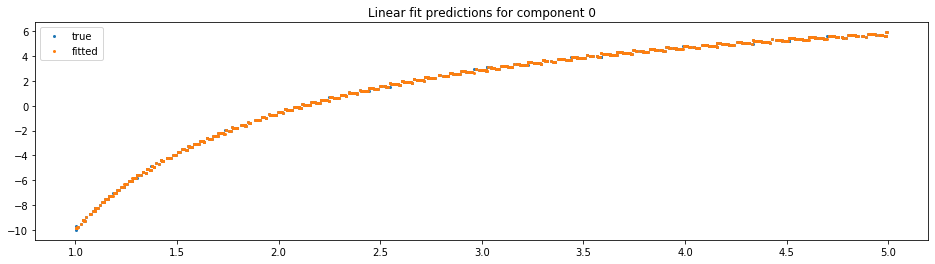

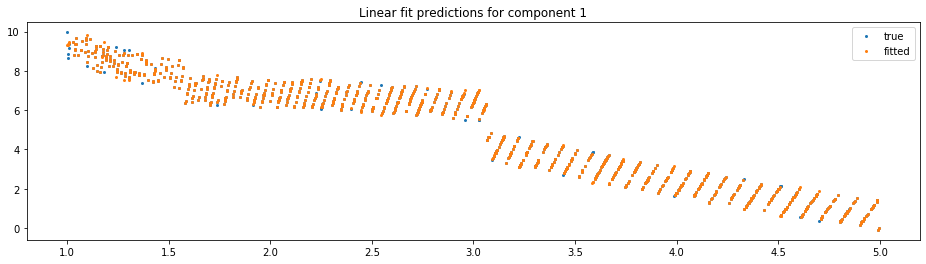

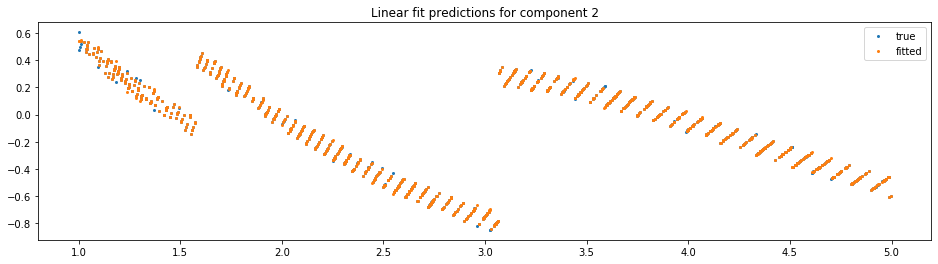

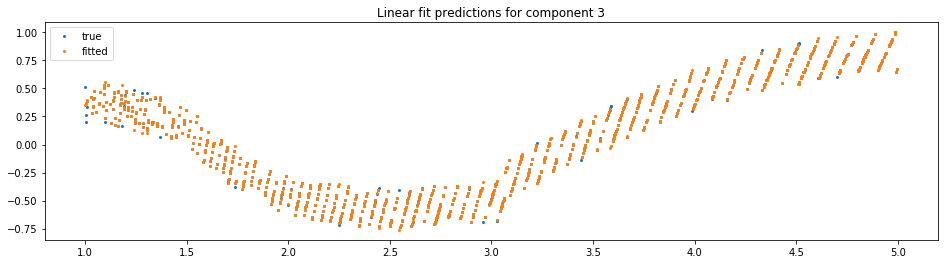

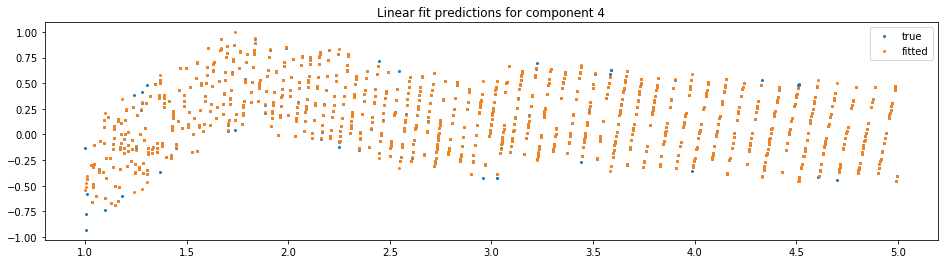

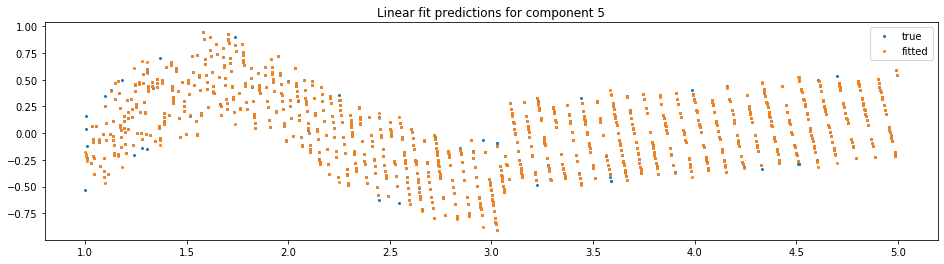

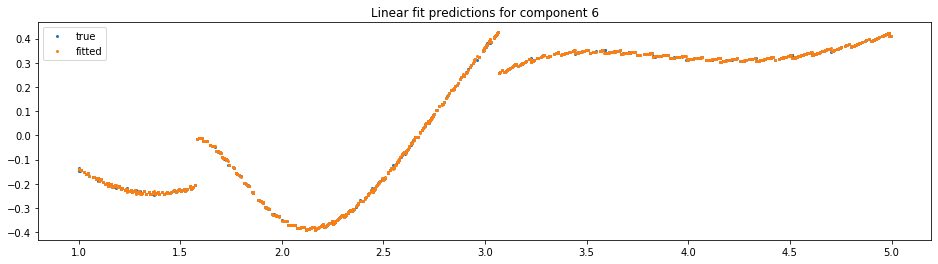

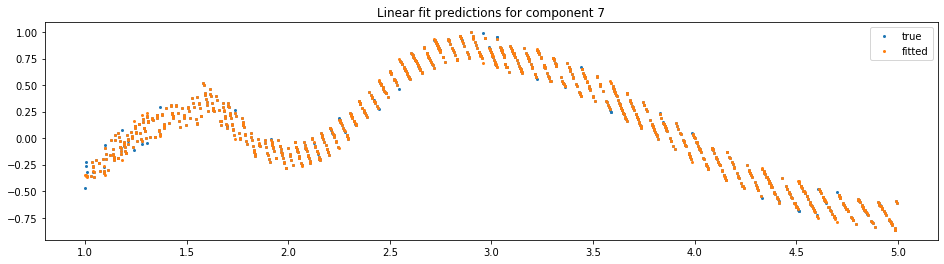

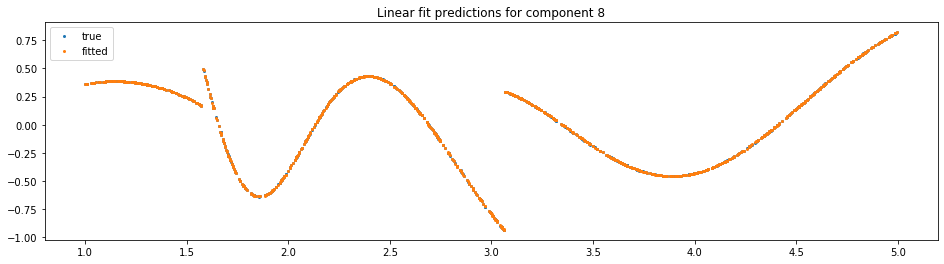

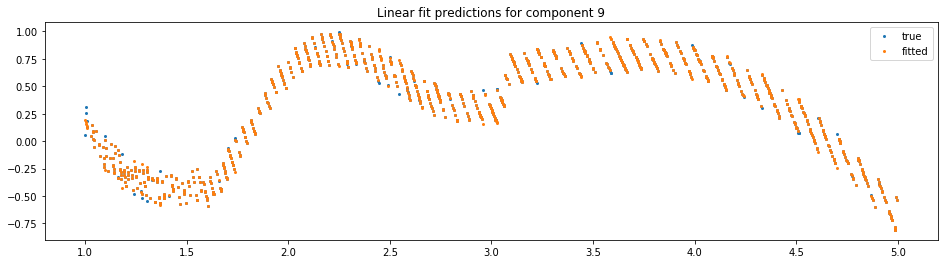

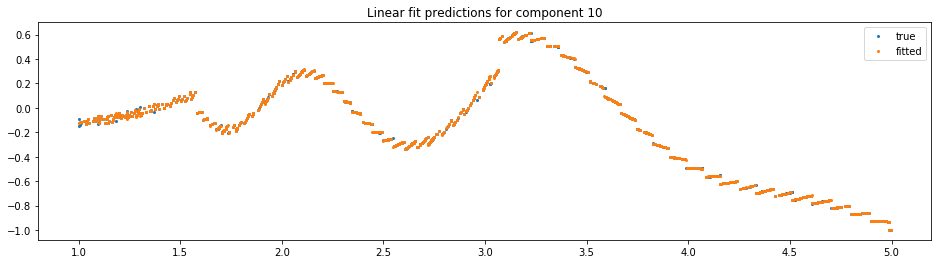

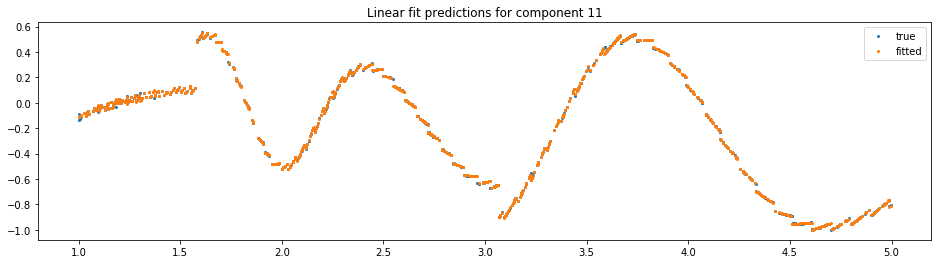

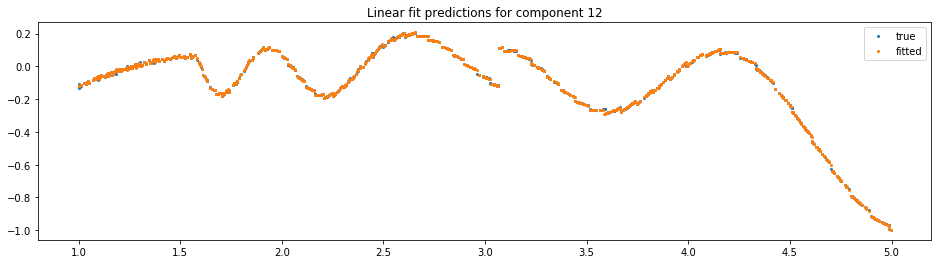

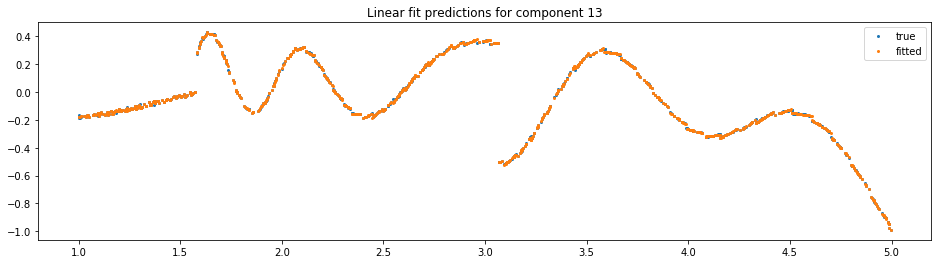

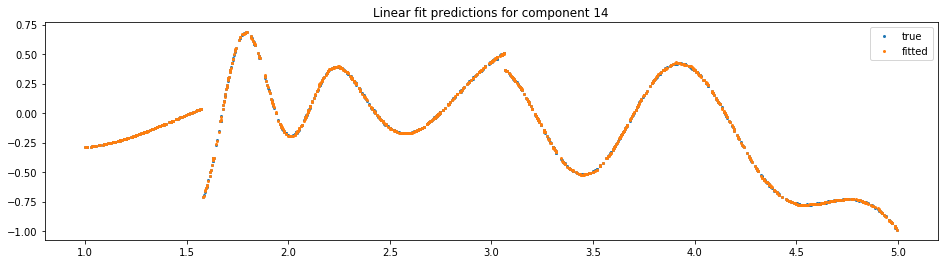

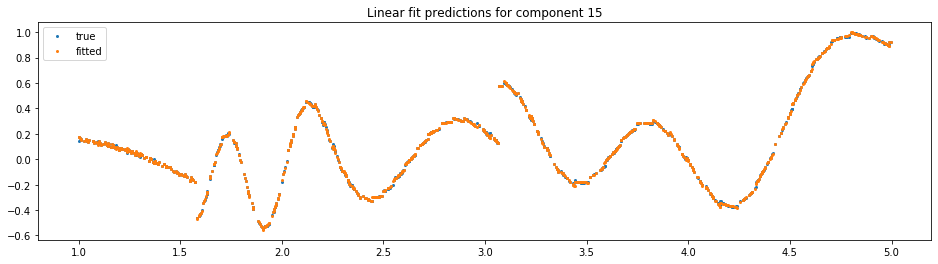

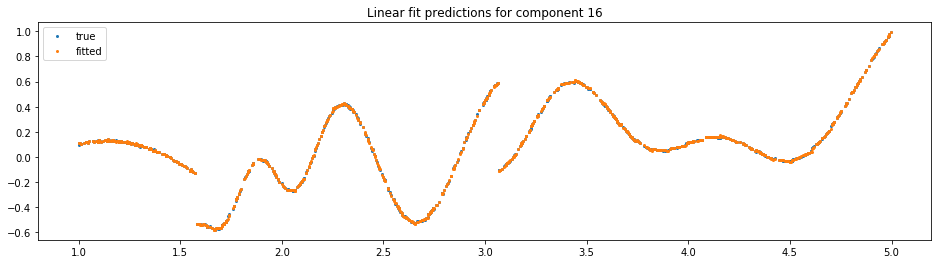

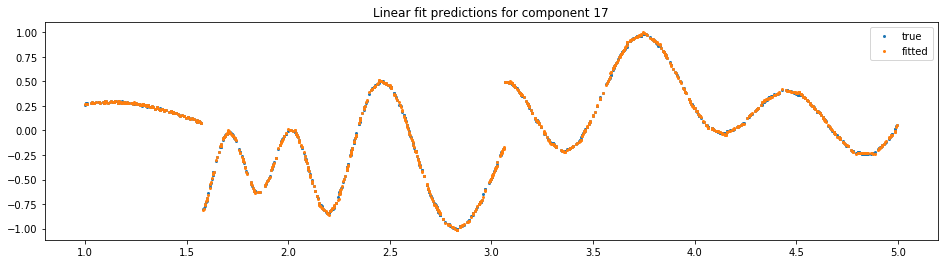

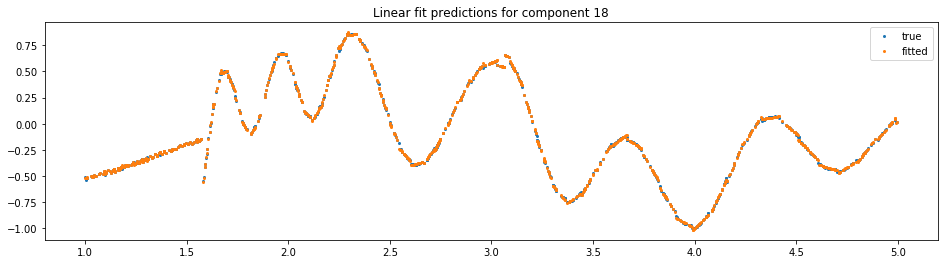

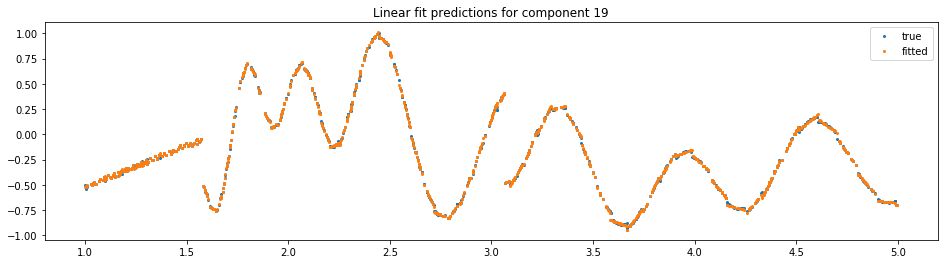

In [7]:
print(val_theta.shape)
    #plotting results
for k in range(PCA_train_ph.shape[1]):
    plt.figure(k, figsize = (16,4))
    plt.title("Linear fit predictions for component "+str(k))
    plt.plot(val_theta, PCA_val_ph[:,k], 'o', ms = 2, label = "true")
    plt.plot(val_theta, PCA_fit_ph[:,k], 'o', ms = 2, label = "fitted")
    plt.legend()
plt.show()

In [8]:
   #doing test on test data (=unseen data) and evaluating performances
N_wf = 500             #number of waveforms to be computed
F = np.zeros((N_wf,))  #holds mismatch between standard and ML for each wave

   #loading PCA model
ph_PCA_model = PCA_model()
ph_PCA_model.load_model("./old_datasets/PCA_std_model.dat")
K = (ph_PCA_model.get_PCA_params()[0]).shape[1]

   #Starting comparison!
start_time = time.process_time_ns()
        #generating std WF
q, amp, ph, frequencies = create_dataset(N_wf, N_grid = 2048, filename = None,
                                             q_range = (1.,5.), s1_range = s[0], s2_range = s[1],
                                             f_high = 1000, f_step = 5e-2, f_max = None, f_min =None,
                                             lal_approximant = "IMRPhenomPv2")
middle_time = time.process_time_ns()
        #generating ML WF
q = np.reshape(q[:,0], (q.shape[0],1))
test_PCA_fit_ph = np.zeros((N_wf, K))
for k in range(K):
    test_PCA_fit_ph[:,k] = linfit_models[k].predict(q) #predictions
test_PCA_fit_ph = np.multiply(test_PCA_fit_ph, max_ph)
rec_ph = ph_PCA_model.reconstruct_data(test_PCA_fit_ph)
end_time = time.process_time_ns() 
    
        #saving time
times = [(middle_time-start_time)/1e9, (end_time-middle_time)/1e9] #holds time elapsed for computing WFs (standard and ML)
    
        #computing and saving mismatch
F = compute_mismatch(amp, ph, amp, rec_ph)

Generated WF  50
Generated WF  100
Generated WF  150
Generated WF  200
Generated WF  250
Generated WF  300
Generated WF  350
Generated WF  400
Generated WF  450


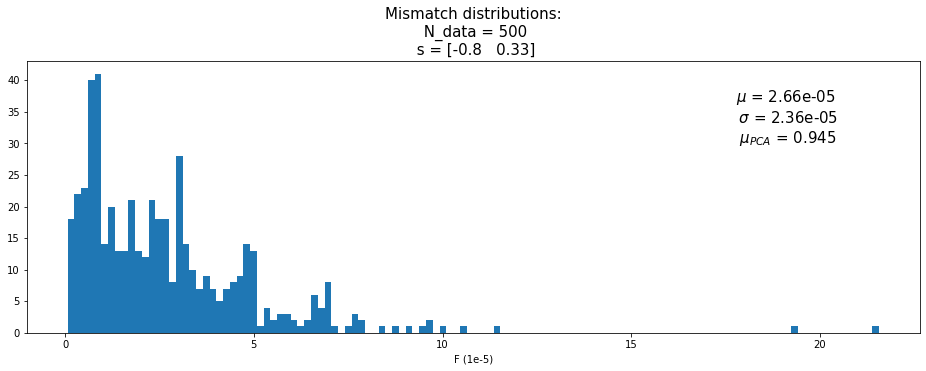

In [9]:
   #plotting histograms of mismatches
F_PCA =  2.8172e-05
plt.figure(figsize=(16,5))
plt.title("Mismatch distributions:\n N_data = "+str(N_wf)+"\n s = "+str(s), fontsize = 15)
plt.hist(F*1e5, bins = 120)
plt.annotate("$\mu$ = "+'{:.2e}'.format(np.mean(F))+"\n $\sigma$ = "+ '{:.2e}'.format(np.std(F))+
             "\n $\mu_{PCA}$ = "+'{:.3}'.format(np.mean(F)/F_PCA),
        xy=(.85, 0.7), xycoords='axes fraction', fontsize = 15,  horizontalalignment='center')

plt.xlabel("F (1e-5)")
plt.show()

Mismatch here should be compared with mismatch of PCA. For the current model with 20 PC, it amounts to: <br>
> Mismatch PCA avg:  2.8172e-05


Now it's time to make comparison between the model and the standard lal model of generating WF.

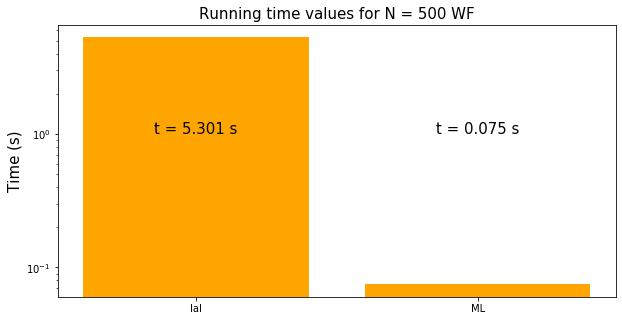

In [10]:
   #plotting histograms of times
plt.figure(figsize=(10,5), )
plt.title("Running time values for N = "+str(N_wf)+" WF",fontsize = 15)
plt.bar(["lal","ML"],times, color = "orange")
plt.text(0,1, "t = "+str(np.round(times[0],3))+" s", fontsize = 15,  horizontalalignment='center')
plt.text(1,1, "t = "+str(np.round(times[1],3))+" s", fontsize = 15,  horizontalalignment='center')
plt.yscale("log")
plt.ylabel("Time (s)", fontsize =15)
plt.show()

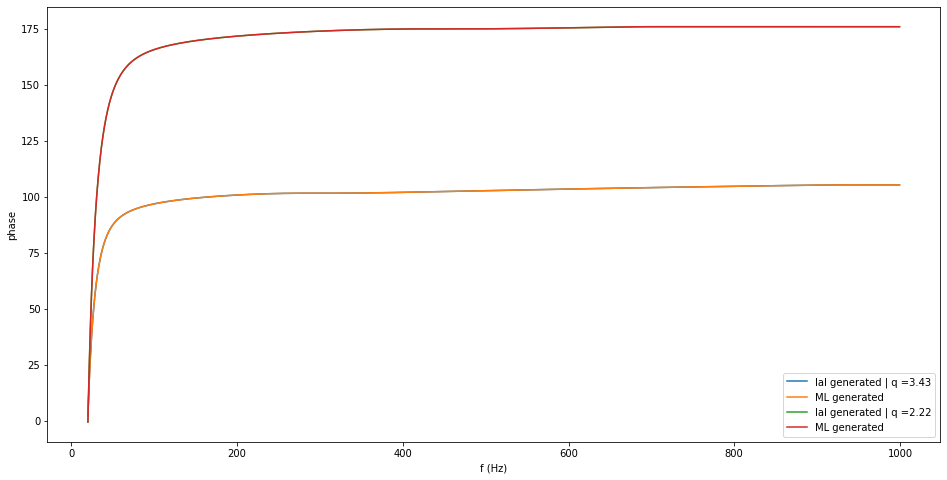

In [11]:
   #plotting for comparison 2 WFs
plt.figure(figsize = (16,8))
plt.plot(frequencies,ph[0,:], label = "lal generated | q ="+str(np.round(q[0,0],2)))
plt.plot(frequencies,rec_ph[0,:], label = "ML generated")
plt.plot(frequencies,ph[1,:], label = "lal generated | q ="+str(np.round(q[1,0],2)))
plt.plot(frequencies,rec_ph[1,:], label = "ML generated")
plt.xlabel("f (Hz)")
plt.ylabel("phase")
plt.legend()
plt.show()